# Abrindo a caixa preta dos algoritmos de ML

## Resumo

### Motivação

Vimos que existem algoritmos de alta interpretabilidade como regressões lineares e arvores de decisão simples. Mas nem sempre (quase nunca) esses algoritmos simples são os que retornam os melhores resultados preditivos (os menores valores na nossa curva de custo). E ficamos nesse impasse, usar algoritmos simples para conseguir explicar como ele chegou nos resultados (e ter mais confiança da área não técnica) ou usar algoritmos super poderosos que não temos a minima ideia de como ele chegou em um resultado qualquer?


Uma saída para isso é usar as duas abordagens. Usa-se um algoritmo simples para sabermos o que está acontecendo e um mais poderoso que é uma caixa-preta para fazer previsões.


Outra saída é tentarmos abrir a caixa preta e entender o que se passa lá.

Vamos usar um dataset com caracteristicas de vinhos para treinarmos esses conceitos.


### O problema

Nesse exemplo

Sabemos fazer as modelagens estatisticas, para entender quanto cada variável impacta no nosso output, entendendo como são suas correlações parciais. Além disso, podemos entender como as variáveis endógenas influenciam umas as outras, e como essas interações influenciam-se.

<img src='https://christophm.github.io/interpretable-ml-book/images/big-picture.png'>


Mas como ter esses mesmos insights em modelos de machine learning "black-box" como ensambles, redes neurais e outros? Na aula de hoje vamos construir a intuição e dar algumas possibilidades.


Usar **modelos lineares** resolve o problema da interpretabilidade. Mas temos pelo 4 grandes problemas.
1) Modelos lineares esperam outputs gaussianos. Solução: Usar modelos generalizados (GLM);

<img src='./img/1-nao-gaussiano.png'> 

2) Modelos lineares não "entendem" a interação entre as variáveis. Solução: Passar as interações explicitamente;

<img src='./img/2-interacao.png'> 

<img src='https://christophm.github.io/interpretable-ml-book/images/interaction-plot-1.png'>

3) Modelos lineares não entendem comportamentos não lineares. Solução: Modelagem estatistica;

<img src='./img/3-nao-linear.png'>
<img src='https://christophm.github.io/interpretable-ml-book/images/nonlinear-effects-1.png'>

4) Modelos lineares são dificieis de modelar para chegar no mesmo nivel de um não linear. Solução: Estudar e praticar bastante.

<img src='https://canaldoensino.com.br/blog/wp-content/uploads/2015/03/descansar-estudo.jpg'>

### Objetivo e Dados

Em nosso exemplo usaremos dados reais de cidadãos americanos para prever qual a probabilidade deles ganharem mais ou menos que US$ 50mil.

Então nossas variáveis explicativas são:

    1- Age
    2- Workclass
    3- Education-Num
    4- Marital Status
    5- Occupation
    6- Relationship
    7- Race
    8- Sex
    9- Capital Gain
    10- Capital Loss
    11- Hours per week
    12- Country

e nosso target:
Individuo ganhou mais de 50mil por ano (booleano)

### Outros Exemplos

- MMNIST: https://github.com/slundberg/shap/blob/master/notebooks/deep_explainer/Front%20Page%20DeepExplainer%20MNIST%20Example.ipynb

- DNA: https://github.com/slundberg/shap/blob/master/notebooks/deep_explainer/DeepExplainer%20Genomics%20Example.ipynb

- LSTM e Análise de Sentimentos: https://github.com/slundberg/shap/blob/master/notebooks/deep_explainer/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.ipynb


### Bibliografia

- https://christophm.github.io/interpretable-ml-book/
- Shapley, Lloyd S. “A value for n-person games.” Contributions to the Theory of Games 2.28 (1953): 307-317.


Wikipedia: "... Desde o trabalho de John von Neumann e Oskar Morgenstern na década de 1940, Lloyd Shapley tem sido considerado a própria personificação da teoria dos jogos. Juntamente com Alvin Roth, foi laureado com o Prémio de Ciências Económicas em Memória de Alfred Nobel de 2012. ..."

In [1]:
# Instalar os pacotes pydot na versão 1.4.1,
# xgboost
# shap em uma linha

In [3]:
# !pip install pydot==1.4.1 xgboost==0.90 shap==0.29.3

In [ ]:
resposta 2

## Carregando os pacotes que usaremos na aula

In [4]:
import xgboost
import shap
import numpy as np
import matplotlib.pylab as plz
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import warnings
import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from io import StringIO


if not sys.warnoptions:
    warnings.simplefilter("ignore")

    
%matplotlib inline
# print the JS visualization code to the notebook
shap.initjs()

## Load dataset

Usaremos como exemplo inicial o dataset "adult" dentro do pacote shap

Então nossas variáveis explicativas são:

    1- Age
    2- Workclass
    3- Education-Num
    4- Marital Status
    5- Occupation
    6- Relationship
    7- Race
    8- Sex
    9- Capital Gain
    10- Capital Loss
    11- Hours per week
    12- Country

e nosso target:
Individuo ganhou mais de 50mil por ano (booleano)


In [5]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

In [8]:
# Separe os dados em treino e teste com a proporção 80~20 e seed = 42
# criando as variaveis: X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# criando o tipo de dados DMatrix que é um array super otimizado dentro do xgboost

d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [12]:
X.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   
1  50.0          6           13.0               2           4             4   
2  38.0          4            9.0               0           6             0   
3  53.0          4            7.0               2           6             4   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

### Análise exploratória de dados

Os impactos das variáveis umas nas outras começa aqui.

In [19]:
X['Marital Status'].value_counts()

2    14976
4    10683
0     4443
5     1025
6      993
3      418
1       23
Name: Marital Status, dtype: int64

In [13]:
X.describe()

Age     Workclass  Education-Num  Marital Status  \
count  32561.000000  32561.000000   32561.000000    32561.000000   
mean      38.581646      3.868892      10.080679        2.611836   
std       13.640442      1.455960       2.572562        1.506222   
min       17.000000      0.000000       1.000000        0.000000   
25%       28.000000      4.000000       9.000000        2.000000   
50%       37.000000      4.000000      10.000000        2.000000   
75%       48.000000      4.000000      12.000000        4.000000   
max       90.000000      8.000000      16.000000        6.000000   

         Occupation  Relationship          Race           Sex  Capital Gain  \
count  32561.000000  32561.000000  32561.000000  32561.000000  32561.000000   
mean       6.572740      2.494518      3.665858      0.669205   1077.649170   
std        4.228857      1.758232      0.848806      0.470506   7385.911621   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.000000      0.000000      4.000000      0.000000      0.000000   
50%        7.000000      3.000000      4.000000      1.000000      0.000000   
75%       10.000000      4.000000      4.000000      1.000000      0.000000   
max       14.000000      5.000000      4.000000      1.000000  99999.000000   

       Capital Loss  Hours per week       Country  
count  32561.000000    32561.000000  32561.000000  
mean      87.303833       40.437454     36.718866  
std      403.014771       12.347933      7.823782  
min        0.000000        1.000000      0.000000  
25%        0.000000       40.000000     39.000000  
50%        0.000000       40.000000     39.000000  
75%        0.000000       45.000000     39.000000  
max     4356.000000       99.000000     41.000000

#### Correlações

In [20]:
X.corr().round(2)

Age  Workclass  Education-Num  Marital Status  Occupation  \
Age             1.00       0.00           0.04           -0.27       -0.02   
Workclass       0.00       1.00           0.05           -0.06        0.25   
Education-Num   0.04       0.05           1.00           -0.07        0.11   
Marital Status -0.27      -0.06          -0.07            1.00       -0.01   
Occupation     -0.02       0.25           0.11           -0.01        1.00   
Relationship    0.09       0.04           0.02           -0.22        0.02   
Race            0.03       0.05           0.03           -0.07        0.01   
Sex             0.09       0.10           0.01           -0.13        0.08   
Capital Gain    0.08       0.03           0.12           -0.04        0.03   
Capital Loss    0.06       0.01           0.08           -0.03        0.02   
Hours per week  0.07       0.14           0.15           -0.19        0.08   
Country        -0.00      -0.01           0.05           -0.02       -0.01   

                Relationship  Race   Sex  Capital Gain  Capital Loss  \
Age                     0.09  0.03  0.09          0.08          0.06   
Workclass               0.04  0.05  0.10          0.03          0.01   
Education-Num           0.02  0.03  0.01          0.12          0.08   
Marital Status         -0.22 -0.07 -0.13         -0.04         -0.03   
Occupation              0.02  0.01  0.08          0.03          0.02   
Relationship            1.00  0.06  0.33          0.06          0.05   
Race                    0.06  1.00  0.09          0.01          0.02   
Sex                     0.33  0.09  1.00          0.05          0.05   
Capital Gain            0.06  0.01  0.05          1.00         -0.03   
Capital Loss            0.05  0.02  0.05         -0.03          1.00   
Hours per week          0.07  0.04  0.23          0.08          0.05   
Country                 0.00  0.14 -0.01         -0.00          0.00   

                Hours per week  Country  
Age                       0.07    -0.00  
Workclass                 0.14    -0.01  
Education-Num             0.15     0.05  
Marital Status           -0.19    -0.02  
Occupation                0.08    -0.01  
Relationship              0.07     0.00  
Race                      0.04     0.14  
Sex                       0.23    -0.01  
Capital Gain              0.08    -0.00  
Capital Loss              0.05     0.00  
Hours per week            1.00    -0.00  
Country                  -0.00     1.00

In [21]:
df = X.copy(deep=True)

df['target'] = y

#### HeatMap com Correlações

In [22]:
# Plote a matriz de correlação na forma de um heatmap

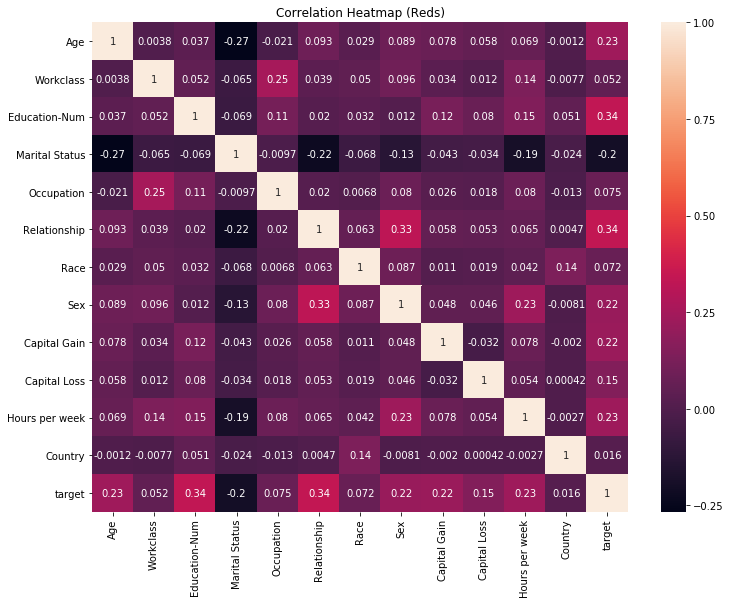

In [23]:
plt.subplots(figsize=(12,9))
ax = plt.axes()
ax.set_title("Correlation Heatmap (Reds)")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True)

plt.show()

#### PairPlot

In [24]:
# Plot agora um pairplot com o target + as 5 variáveis mais correlacionadas com o y

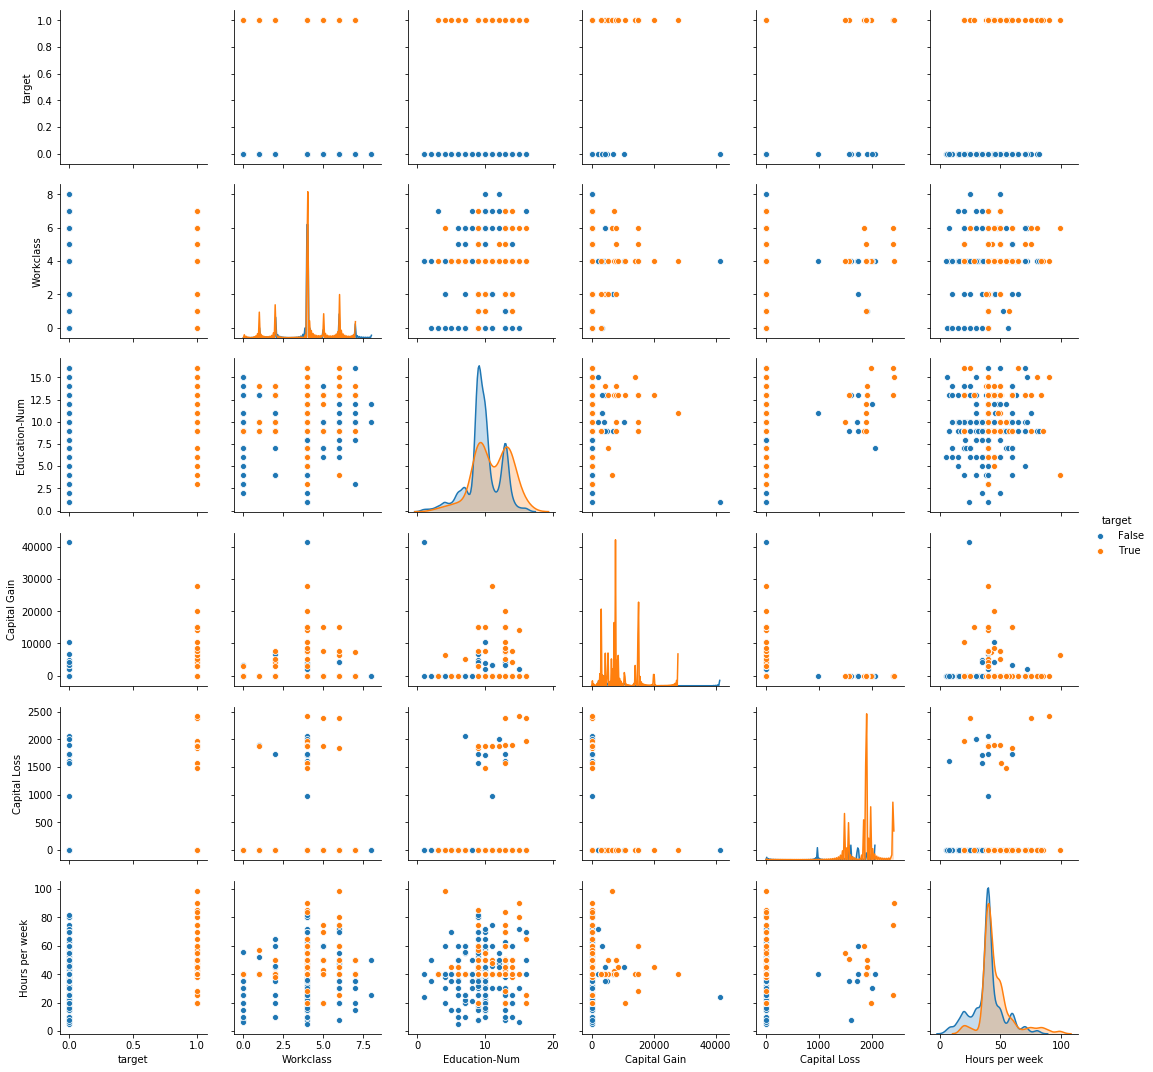

In [25]:
cols = ['target','Workclass', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week']
sns.pairplot(df[cols].sample(500), hue='target')

## Usando modelos lineares para entender o impacto das features

In [26]:
df.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             0   
1  50.0          6           13.0               2           4             4   
2  38.0          4            9.0               0           6             0   
3  53.0          4            7.0               2           6             4   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  target  
0     4    1        2174.0           0.0            40.0       39   False  
1     4    1           0.0           0.0            13.0       39   False  
2     4    1           0.0           0.0            40.0       39   False  
3     2    1           0.0           0.0            40.0       39   False  
4     2    0           0.0           0.0            40.0        5   False

In [27]:
# ajustando o nome das colunas para funcionarem no statsmodel api
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '')

In [28]:
df['target'] = df['target'].astype(int)

In [29]:
function = '''
target ~ Age
+ Workclass 
+ EducationNum 
+ MaritalStatus
+ CapitalGain
+ CapitalLoss 
+ Hoursperweek'''

results = smf.ols(function, data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     1440.
Date:                Mon, 01 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:31:36   Log-Likelihood:                -14147.
No. Observations:               32561   AIC:                         2.831e+04
Df Residuals:                   32553   BIC:                         2.838e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.5681      0.014    -40.072

In [30]:
function = '''
target ~ Age
+ Workclass 
+ EducationNum 
+ MaritalStatus
+ C(Occupation)
+ C(Relationship) 
+ C(Race)
+ C(Sex)
+ CapitalGain
+ CapitalLoss 
+ Hoursperweek
+ C(Country)'''

results = smf.ols(function, data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     254.2
Date:                Mon, 01 Jul 2019   Prob (F-statistic):               0.00
Time:                        05:33:14   Log-Likelihood:                -11262.
No. Observations:               32561   AIC:                         2.267e+04
Df Residuals:                   32488   BIC:                         2.328e+04
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.6428 

strong multicollinearity or other numerical problems.


### Parenteses para explicar simplificadamente como a arvore de decisão cria suas fronteiras de decisão com o famoso dataset IRIS


Note que para "profundidades" maiores que 3, o algoritmo passa a conseguir (se for necessário) interagir as variáveis.

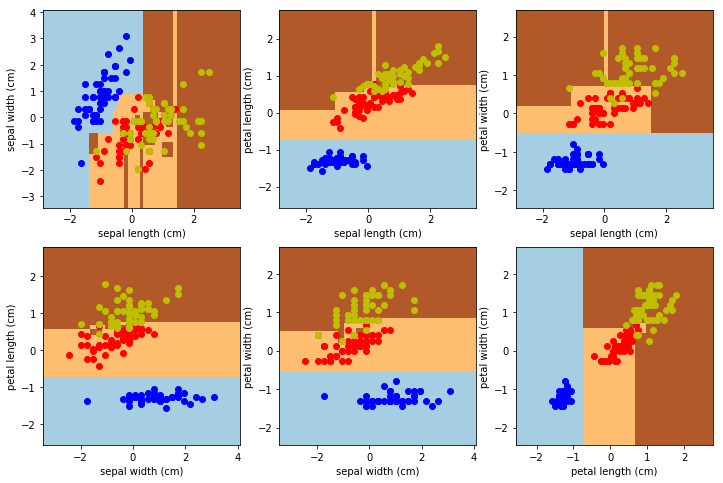

In [31]:
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
 
# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02
plt.rcParams["figure.figsize"] = [12, 8]
 
# Load data
iris = load_iris()

def runExampleIris():
    for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                    [1, 2], [1, 3], [2, 3]]):

        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(13)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = DecisionTreeClassifier().fit(X, y)

        # Plot the decision boundary
        plt.subplot(2, 3, pairidx + 1)

        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        cs = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

        plt.xlabel(iris.feature_names[pair[0]])
        plt.ylabel(iris.feature_names[pair[1]])
        plt.axis()

        # Plot the training points
        for i, color in zip(range(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=color,
                        label=iris.target_names[i],
                        cmap=plt.cm.Paired)
        plt.axis()

    plt.show()
    
runExampleIris()

## Usando modelos de arvore de decisão para entender o impacto e a relação entre as variáveis do dataset de renda.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

dtr = DecisionTreeClassifier(max_depth=3)
dtr.fit(X_train, y_train)
yhat = dtr.predict(X_test)
yhat_proba = 1-dtr.predict_proba(X_test)[:, :1]
yhat_proba_train = 1-dtr.predict_proba(X_train)[:, :1]

precision = metrics.precision_score(y_test, yhat)
recall = metrics.recall_score(y_test, yhat)
auc = metrics.roc_auc_score(y_test, yhat_proba)

print(
    f'Precisao: {round(precision,4)}, Recall:{round(recall,4)}, AUC:{round(auc,4)}')

Precisao: 0.7628, Recall:0.5043, AUC:0.8596


### Plotando as métricas:

- Para entender o porquê e como utilizar ROC e AUC: https://lukeoakdenrayner.wordpress.com/2018/01/07/the-philosophical-argument-for-using-roc-curves/

Confusion matrix, without normalization
[[7796  400]
 [1264 1286]]


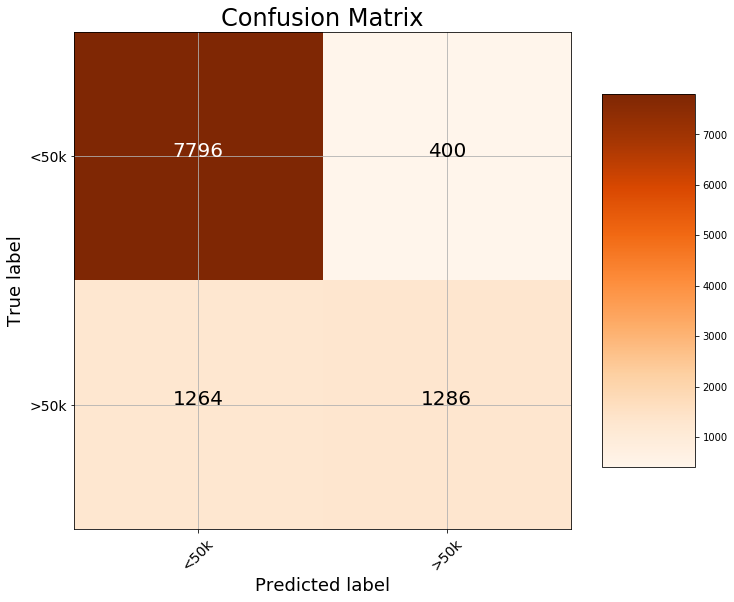

In [33]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size=18)
    plt.xlabel('Predicted label', size=18)


# Confusion matrix
cm = confusion_matrix(y_test, yhat)

plot_confusion_matrix(cm, classes=['<50k', '>50k'],
                      title='Confusion Matrix')

plt.savefig('cm.png')

AUC:0.8596


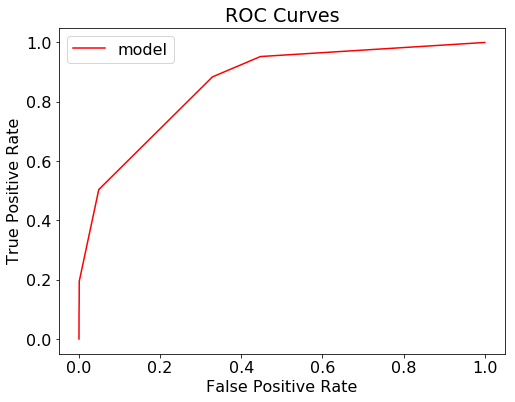

In [34]:
# Calculate false positive rates and true positive rates
model_fpr, model_tpr, _ = metrics.roc_curve(y_test, yhat_proba)
plt.figure(figsize=(8, 6))
plt.rcParams['font.size'] = 16
# Plot both curves
plt.plot(model_fpr, model_tpr, 'r', label='model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
print(f'AUC:{round(auc,4)}')
plt.show()

In [ ]:
### E por fim a própria arvore de decisão gerada

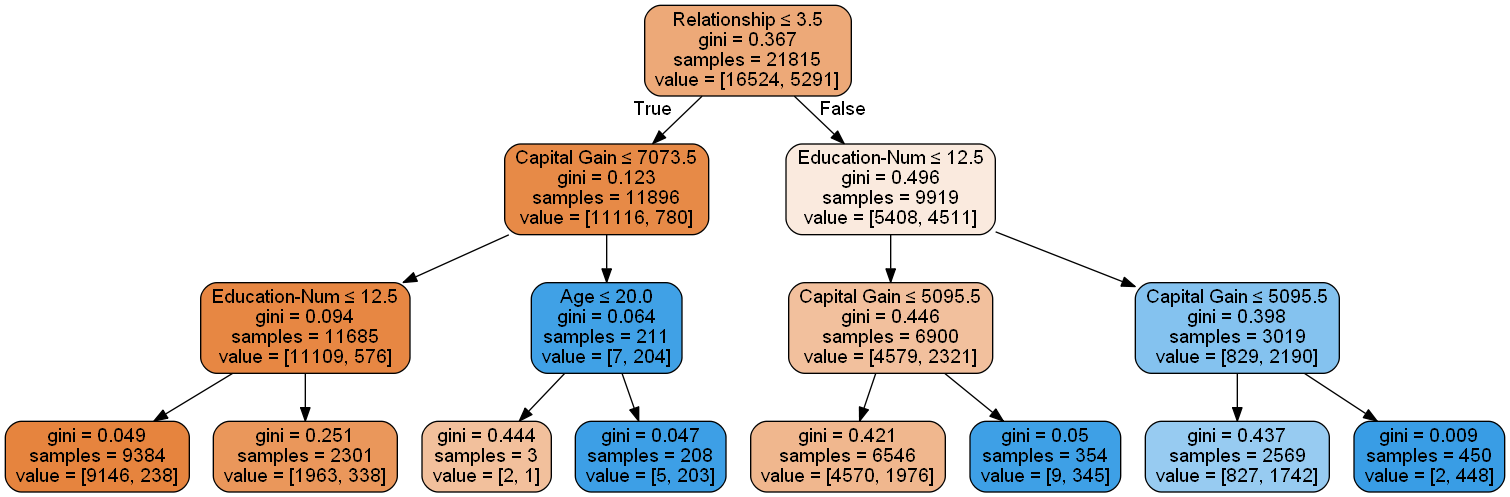

In [35]:
dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=list(X))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Enquanto a arvore é pouco profunda, podemos entender, mas e quando a arvore é profunda??

Precisao: 0.7936, Recall:0.5337, AUC:0.8987


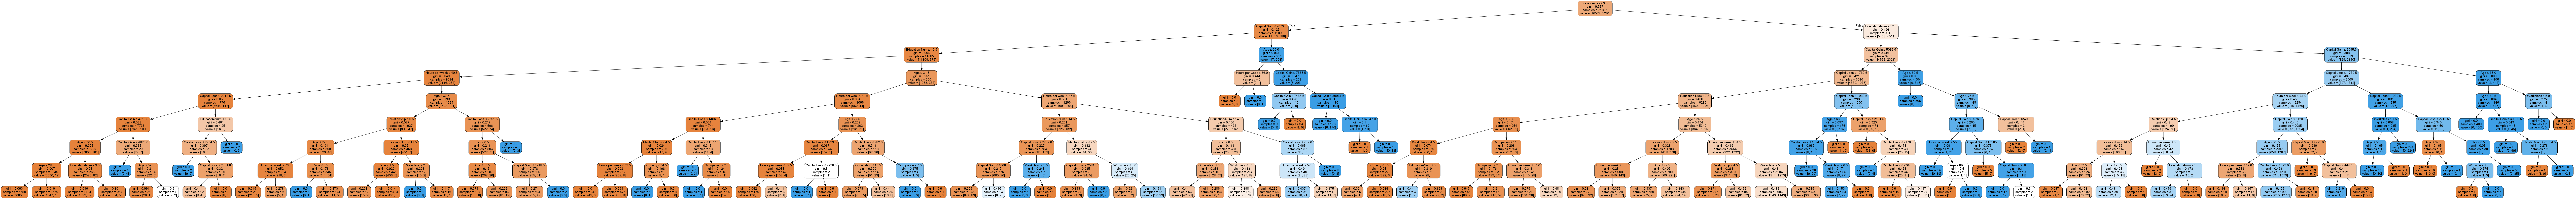

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

dtr = DecisionTreeClassifier(max_depth=8)
dtr.fit(X_train, y_train)
yhat = dtr.predict(X_test)
yhat_proba = 1-dtr.predict_proba(X_test)[:, :1]
yhat_proba_train = 1-dtr.predict_proba(X_train)[:, :1]

precision = metrics.precision_score(y_test, yhat)
recall = metrics.recall_score(y_test, yhat)
auc = metrics.roc_auc_score(y_test, yhat_proba)

print(
    f'Precisao: {round(precision,4)}, Recall:{round(recall,4)}, AUC:{round(auc,4)}')

dot_data = StringIO()
export_graphviz(dtr,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=list(X))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

### Usando Algoritmo de BlackBox

Neste caso vamos usar um xgboost como algoritmo de black-box ...

Leia mais sobre o xgboost nesses links:

- https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost/
- https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
- https://towardsdatascience.com/exploring-xgboost-4baf9ace0cf6


### Além disso vamos fazer o tunning dos hyperparametros utilizando RandomizedSearch ao invés do simples GridSearch

In [37]:
# Create XGB Classifier object
xgb_clf = xgboost.XGBClassifier(eval_metric=[
                                "merror", "map", "auc"], objective="binary:logistic")

# Altere os parametros para tree_method = "gpu_exact" e predictor = "gpu_predictor" para rodar o modelo na GPU (precisa instalar CUDA)

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
              "gamma": [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
              "max_depth": [2, 4, 7, 10],
              "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
              "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
              "reg_alpha": [0, 0.5, 1],
              "reg_lambda": [1, 1.5, 2, 3, 4.5],
              "min_child_weight": [1, 3, 5, 7],
              "n_estimators": [100]}

# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions=parameters,
                              scoring="f1_micro", cv=3,
                              random_state=42, verbose=True, n_jobs=-1)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.0s finished


In [38]:
xgb_rscv.best_params_

{'subsample': 0.4,
 'reg_lambda': 1.5,
 'reg_alpha': 0.5,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [39]:
# params = {
#     "eta": 0.01,
#     "objective": "binary:logistic",
#     "subsample": 0.5,
#     "base_score": np.mean(y_train),
#     "eval_metric": "logloss"
# }

# # or 

params = model_xgboost.best_params_

In [40]:
model = xgboost.train(params, d_train, 1500, evals=[
                      (d_test, "test")], verbose_eval=25, early_stopping_rounds=10)

[0]	test-rmse:0.474158
Will train until test-rmse hasn't improved in 10 rounds.
[25]	test-rmse:0.306679
[50]	test-rmse:0.301589
[75]	test-rmse:0.300907
[100]	test-rmse:0.300635
[125]	test-rmse:0.300324
[150]	test-rmse:0.300293
Stopping. Best iteration:
[154]	test-rmse:0.300242



## Classic feature attributions

Aqui nós experimentamos os cálculos de importância do recurso global que vêm com o XGBoost. Note que todos eles se contradizem, o que motiva o uso de valores SHAP, uma vez que eles vêm com consistência gaurentees (o que significa que eles vão ordenar os recursos corretamente).

* "weight" é o número de vezes que um recurso aparece em uma árvore
* "gain" é o ganho médio de divisões que usam o recurso
* "cover" é a cobertura média de divisões que usam o recurso em que a cobertura é definida como o número de amostras afetadas pelo desdobramento

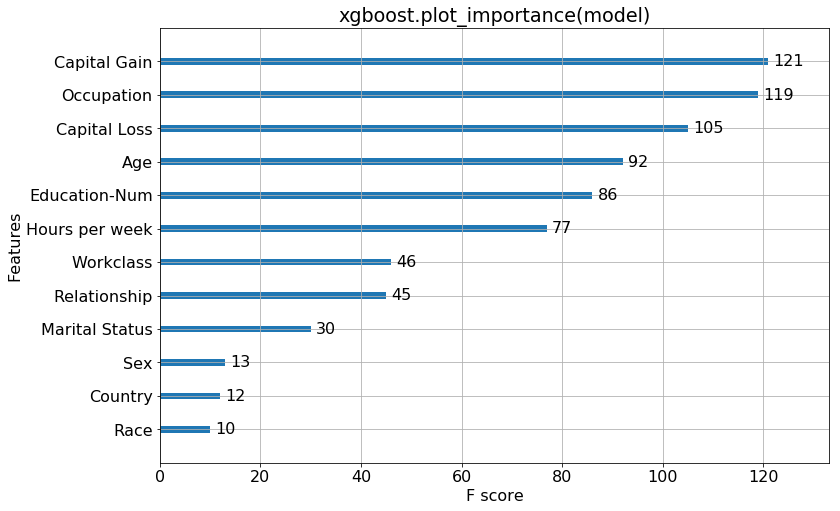

In [41]:
xgboost.plot_importance(model)
plt.title("xgboost.plot_importance(model)")
plt.show()

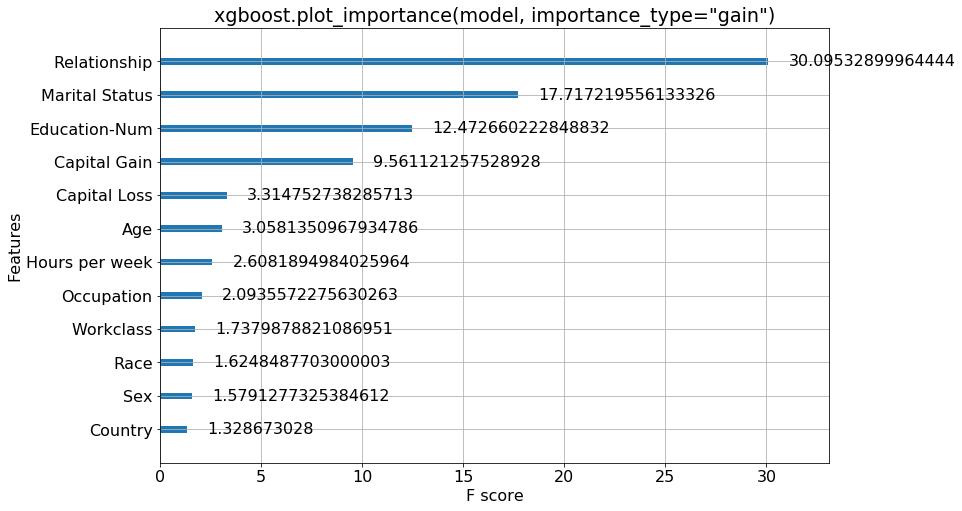

In [43]:
xgboost.plot_importance(model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

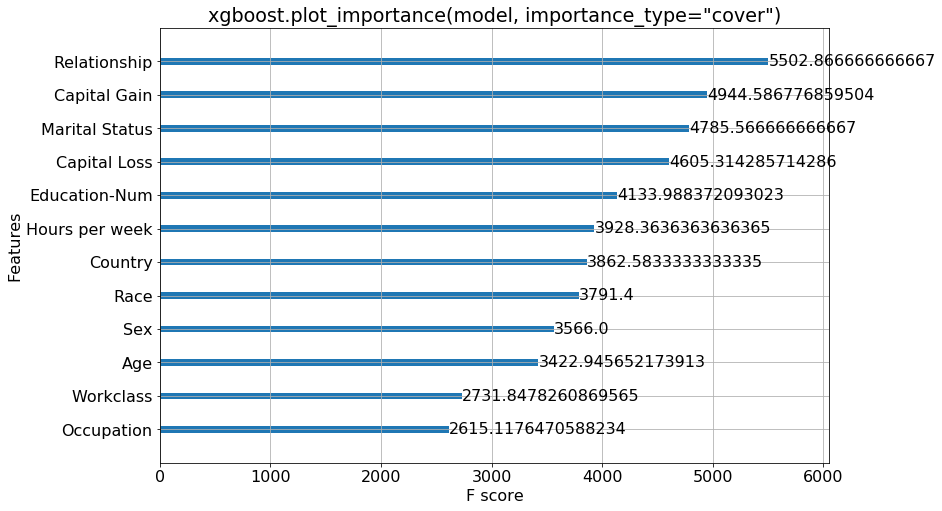

In [42]:
xgboost.plot_importance(model, importance_type="cover")
plt.title('xgboost.plot_importance(model, importance_type="cover")')
plt.show()

## Explain predictions

Aqui usamos a implementação Tree SHAP integrada no XGBoost para explicar o conjunto de dados inteiro (32561 amostras).

In [45]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

### Visualize a single prediction

Observe que usamos o quadro de dados "valores de exibição" para obter strings interessantes em vez de códigos de categoria.

In [54]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X_display.iloc[0,:])

### Visualize many predictions

Para manter o navegador feliz, visualizamos apenas 1.000 pessoas.

In [56]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

## Bar chart of mean importance

This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

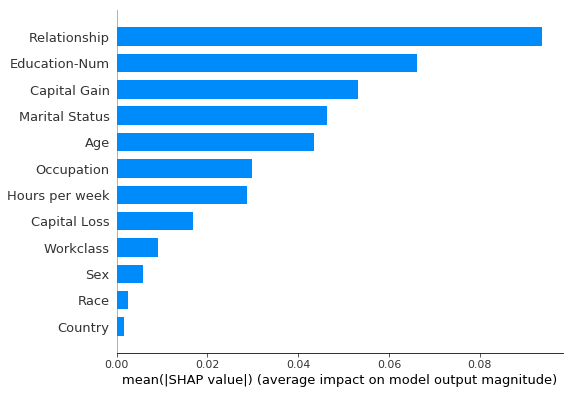

In [57]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

## SHAP Summary Plot

Em vez de usar um gráfico de barras de importância de recurso típico, usamos um gráfico de dispersão de densidade de valores SHAP para cada recurso para identificar quanto impacto cada recurso tem na saída do modelo para indivíduos no conjunto de dados de validação. Os recursos são classificados pela soma das magnitudes do valor SHAP em todas as amostras. É interessante notar que o recurso de relacionamento tem mais impacto total sobre o modelo do que o ganho captural, mas para aquelas amostras onde o ganho de capital é importante ele tem mais impacto que a idade. Em outras palavras, o ganho de capital afeta algumas previsões em grande quantidade, enquanto a idade afeta todas as previsões em uma quantidade menor. Observe que, quando os pontos de dispersão não se encaixam em uma linha, eles se acumulam para mostrar a densidade e a cor de cada ponto representa o valor do recurso desse indivíduo.

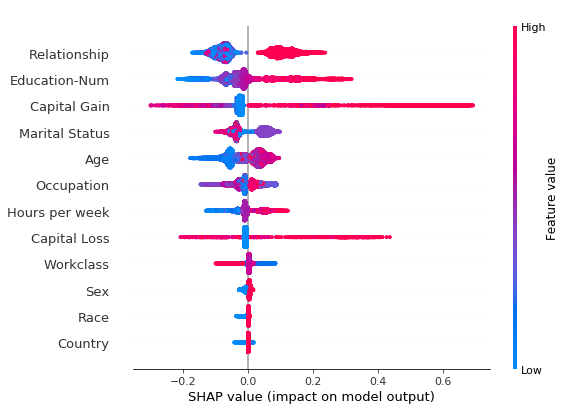

In [58]:
shap.summary_plot(shap_values, X)

## SHAP Dependence Plots

Os gráficos de dependência SHAP mostram o efeito de um único recurso em todo o conjunto de dados. Eles plotam o valor de um recurso versus o valor SHAP desse recurso em várias amostras. Os gráficos de dependência SHAP são semelhantes aos gráficos de dependência parcial, mas são responsáveis ​​pelos efeitos de interação presentes nos recursos e são definidos apenas nas regiões do espaço de entrada suportado pelos dados. A dispersão vertical de valores de SHAP em um único valor de recurso é impulsionada por efeitos de interação, e outro recurso é escolhido para colorir para destacar possíveis interações.

In [59]:
example_cols = ['Age', 'Education-Num', 'Hours per week', 'Sex']

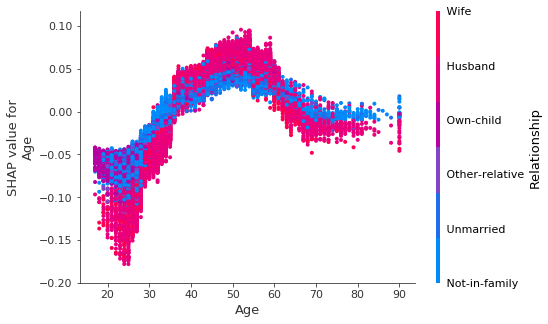

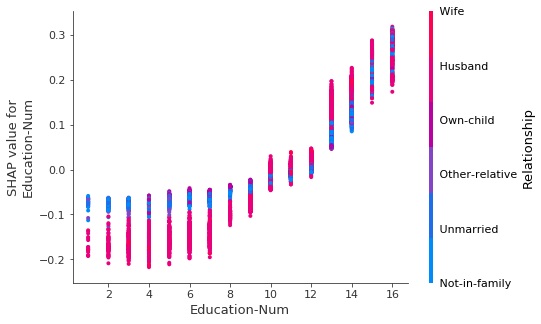

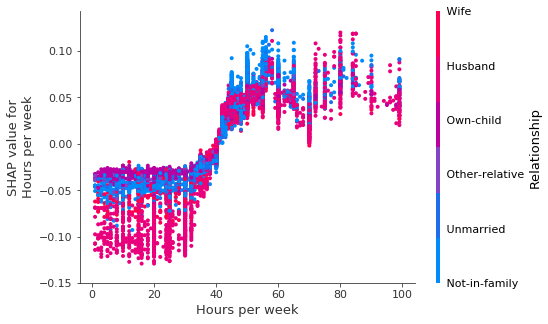

TypeError: set_xticks() got an unexpected keyword argument 'rotation'

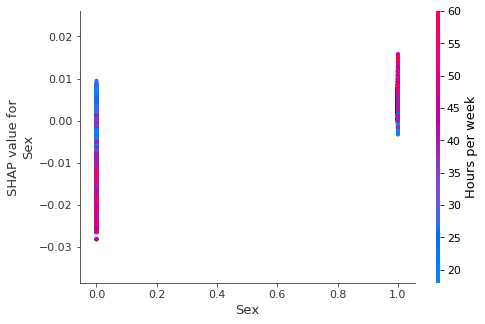

In [60]:
for name in example_cols:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)

### Treine um modelo com apenas duas folhas por árvore e, portanto, sem termos de interação entre os recursos


Forçar o modelo a não ter termos de interação significa que o efeito de um recurso no resultado não depende do valor de qualquer outro recurso. Isso é refletido nos gráficos de dependência SHAP abaixo, como nenhum spread vertical. Um spread vertical reflete que um único valor de um recurso pode ter diferentes efeitos no resultado do modelo, dependendo do contexto dos outros recursos presentes para um indivíduo. No entanto, para modelos sem termos de interação, um recurso sempre tem o mesmo impacto, independentemente de quais outros atributos um indivíduo possa ter. Um dos benefícios dos gráficos de dependência SHAP em relação aos gráficos de dependência parcial tradicionais é essa capacidade de distinguir entre modelos com e sem termos de interação. Em outras palavras, os gráficos de dependência SHAP dão uma ideia da magnitude dos termos de interação através da variância vertical do gráfico de dispersão em um determinado valor de recurso.

[0]	test-logloss:0.542903
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.353631
[200]	test-logloss:0.323989
[300]	test-logloss:0.313584
[400]	test-logloss:0.307951
[500]	test-logloss:0.303529
[600]	test-logloss:0.300575
[700]	test-logloss:0.297975
[800]	test-logloss:0.295937
[900]	test-logloss:0.294502
[1000]	test-logloss:0.293203
[1100]	test-logloss:0.292212
[1200]	test-logloss:0.291335
[1300]	test-logloss:0.290634
[1400]	test-logloss:0.289969
[1500]	test-logloss:0.289235
[1600]	test-logloss:0.28862
[1700]	test-logloss:0.288233
[1800]	test-logloss:0.287737
[1900]	test-logloss:0.287319
[1999]	test-logloss:0.286798


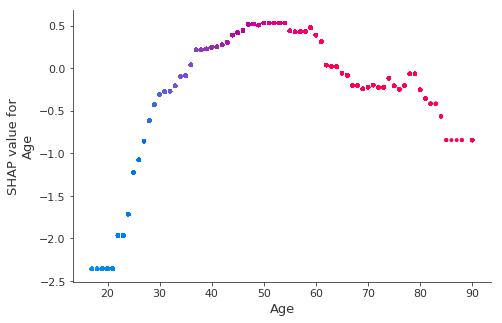

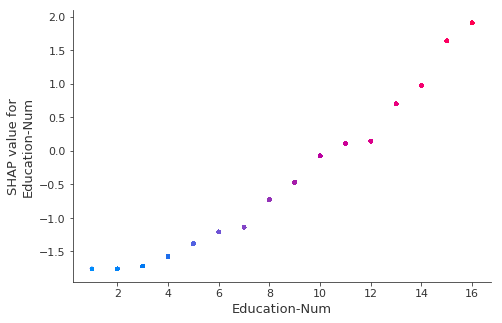

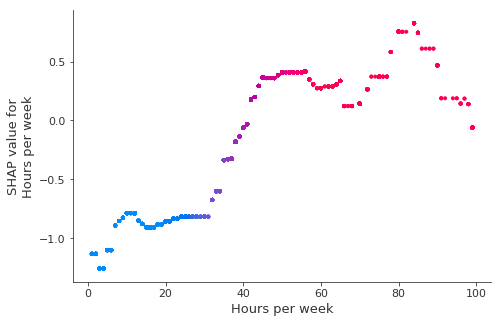

TypeError: set_xticks() got an unexpected keyword argument 'rotation'

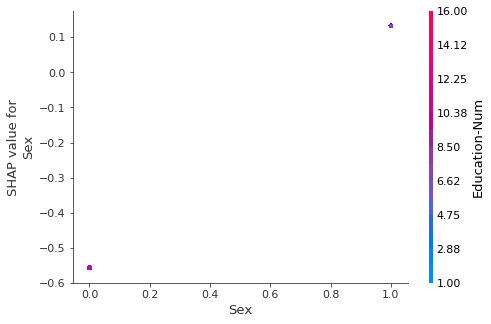

In [61]:
# train final model on the full data set
params = {
    "eta": 0.05,
    "max_depth": 1,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}

model_ind = xgboost.train(params, d_train, 2000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

for name in example_cols:
    shap.dependence_plot(name, shap_values_ind, X, display_features=X_display)